<a href="https://colab.research.google.com/github/kojiyam/denso/blob/master/modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 可聴帯域搬送波のQPSK変調信号

式番号は守倉他『通信方式』

In [2]:
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
plt.style.use('dark_background') # for dark-mode
plt.rcParams["font.size"] = 16

import IPython.display

`Ts` は，(12.1)などではシンボル長 $T$

In [4]:
N = 10  # Number of symbols
Ts = 1 # Symbol length (s/symbol)
sampling_rate = 10000 # 音として出力するためのサンプリング周波数．変調とは関係なし


`B` は (12.9) $ (b_{nM},b_{nM+1},\dots,b_{(n+1)M-1} ) $

$M$ は1シンボルあたりのビット数．ここではQPSKのため，$M=2$



In [5]:
B = np.random.randint(0, 4, N) # 2 bitを表す [0,3] の一様乱数N個．ビット系列 bit sequence

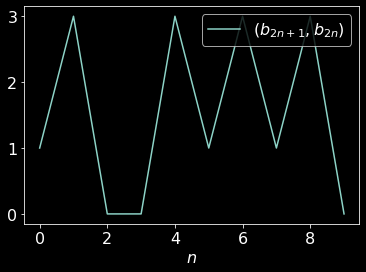

In [6]:
plt.plot(B, label='$(b_{2n+1},b_{2n})$')
plt.xlabel('$n$')
plt.legend(loc='upper right')
plt.show()

縦軸は $ B_n := 2 b_{n+1} + b_{2n} $

例えば，縦軸が2であれば $(b_{2n+1},b_{2n})=(1,0)$


`A` は (12.9) $ a_n = \exp(\mathrm{j} \pi (1+2 B_n)/4)$

In [7]:
A = np.exp(1j * (1/4 + B/2) * np.pi) # QPSK

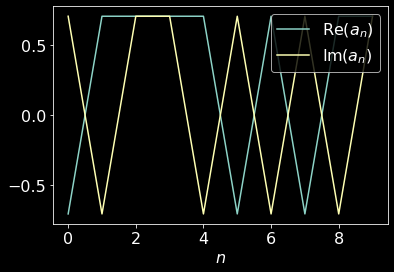

In [52]:
plt.plot(A.real, label='$\mathrm{Re}(a_n)$')
plt.plot(A.imag, label='$\mathrm{Im}(a_n)$')
plt.xlabel('$n$')
plt.legend(loc='upper right')
plt.show()

(離散時間)系列から，(連続時間)信号に

In [9]:
# Rectangular pulse filter
# b = np.repeat(sQ,Ts*Fs)

(12.10) $ \displaystyle x(t) = \sum_{n=-\infty}^\infty a_n \, \delta(t-nT) $

第1刷の$\delta$の表記で，δ関数ではない

In [10]:
# XはA[0], 0, ..., 0, A[1], 0, ..., 0, A[2] という系列
x = np.ravel( np.concatenate([np.reshape(A,(N,1)), 
                              np.zeros([N,sampling_rate*Ts-1]) ], axis=1) )
t = np.arange(N*sampling_rate)/sampling_rate

In [11]:
# xは以下でも作ることができる
# x = np.empty(0)
# for i in range(N):
#    x = np.concatenate([x, np.atleast_1d(A[i]), np.zeros(sampling_rate*Ts-1)])

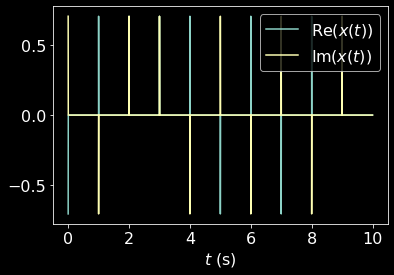

In [53]:
plt.plot(t, x.real, label='$ \mathrm{Re} (x(t)) $')
plt.plot(t, x.imag, label='$ \mathrm{Im} (x(t)) $')
plt.xlabel('$t$ (s)')
plt.legend(loc='upper right')

横軸は時間に変わっていることに注意

『通信方式』11.5節 ルート2乗余弦フィルタ（Root raised cosine filter） を適用

In [13]:
## Root raised cosine filter のためのライブラリ
!pip install scikit-commpy
from commpy.filters import rrcosfilter

In [60]:
# フィルタのインパルス応答を生成
# ここでは，前後6シンボル分の波形に限定（パルステイル打ち切り．p.111）
# ロールオフファクタ alpha=0.8
sPSF = rrcosfilter(Ts*sampling_rate*6, 0.8, Ts, sampling_rate)[1]
t0 = np.arange(sPSF.size)/sampling_rate

Text(0.5, 0, '(s)')

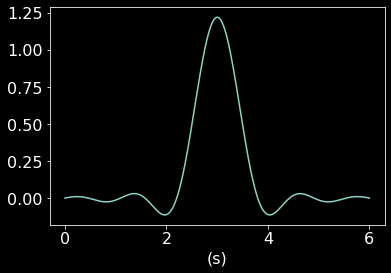

In [23]:
plt.plot(t0,sPSF)
plt.xlabel('(s)')

フィルタの前後分時間が増えるので，`t` とは別に `t2` を作る

以下の `x2` が，(12.10) でフィルタを考えた場合の $x(t)$

In [25]:
# ベースバンド信号
x2 = np.convolve(sPSF, x) # Waveform with PSF
t2 = np.arange(x2.size)/sampling_rate

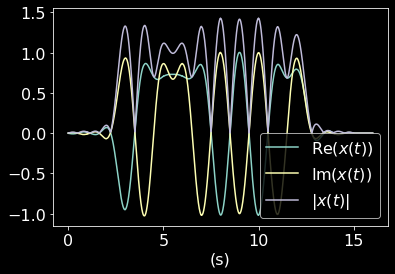

In [54]:
plt.plot(t2, x2.real, label='$\mathrm{Re}(x(t))$')
plt.plot(t2, x2.imag, label='$\mathrm{Im}(x(t))$')
plt.plot(t2, np.abs(x2), label='$|x(t)|$')
plt.xlabel('(s)')
plt.legend(loc='lower right')

https://stackoverflow.com/questions/14614966/easy-way-to-implement-a-root-raised-cosine-rrc-filter-using-python-numpy

In [34]:
Z = 1000 # 動画のための間引き
x2.size, int(x2.size/Z)

(159999, 159)

In [35]:
# 動画のためのライブラリ
!pip install APNG
from apng import APNG

$ x(t) $ の複素平面上での様子

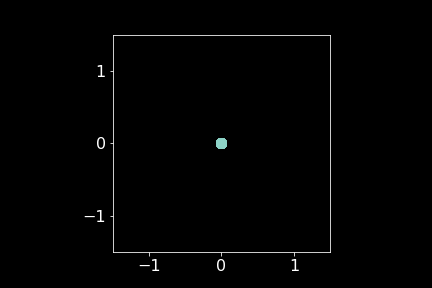

In [38]:
# 動画作成．時間かかる
files = []
for i in range(int(x2.size/Z)):
  filename = "file%03d.png" % i
  fig = plt.figure()
  ax = fig.add_subplot(111)
  plt.scatter(x2.real[i*Z:i*Z+Z], x2.imag[i*Z:i*Z+Z], s=100)
  plt.xlim(-1.5,1.5)
  plt.ylim(-1.5,1.5)
  plt.yticks(np.arange(-1, 1 + 1, 1))
  ax.set_aspect('equal', adjustable='box')
  plt.savefig(filename)
  plt.close(fig)
  files.append(filename)
APNG.from_files(files, delay=int(1000*Z/sampling_rate)).save("animation.png")
IPython.display.Image("animation.png")

In [ ]:
# 搬送波のパラメータ
Ac = 0.6
fc = 523 # (Hz) Carrier frequency

(12.11) $ s(t) = \mathrm{Re} [ A_\mathrm{c} \mathrm{e}^{\mathrm{j} 2\pi f_\mathrm{c} t} x(t) ] $

In [50]:
s = np.real( Ac * np.exp( (1j) * 2 * np.pi * fc * t2) * x2 )

In [51]:
IPython.display.Audio(s, rate = sampling_rate)

Text(0, 0.5, '$s(t)$')

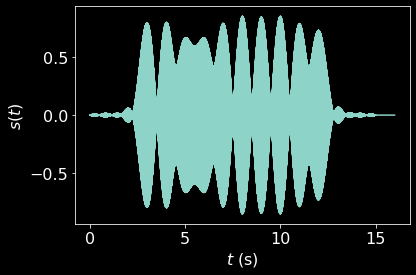

In [48]:
plt.plot(t2, s)
plt.xlabel('$t$ (s)')
plt.ylabel('$s(t)$')

Text(0, 0.5, '$s(t)$')

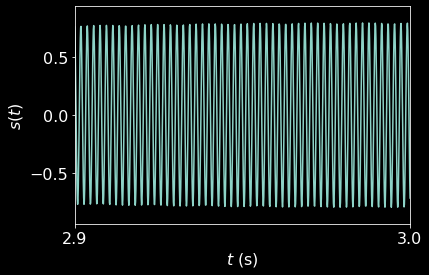

In [58]:
plt.plot(t2, s)
plt.xlim(2.9,3)
plt.xticks(np.arange(2.9, 3.0, 0.1))
plt.xlabel('$t$ (s)')
plt.ylabel('$s(t)$')

## メモ

フーリエ変換

短時間フーリエ変換